# Ising NNN 400

## Init

In [6]:
import concurrent.futures
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.special
import sys
from tqdm import tqdm

_IPYTHON_PATH = os.path.expanduser("~/.ipython/") # TODO:9:remove
_MY_PKG_PATHS = [_IPYTHON_PATH]
for my_pkg_path in _MY_PKG_PATHS:
    my_pkg_paths = [my_pkg_path, os.path.expanduser(my_pkg_path)]
    my_pkg_paths.append(os.path.realpath(my_pkg_paths[-1]))
    if all(x not in sys.path for x in my_pkg_paths):
        sys.path.append(my_pkg_paths[-1])
        
import classifim_gen
import classifim.bench.bits
import classifim.bench.fidelity
import classifim_gen.ising_mcmc
import classifim.bench.metric
import classifim.utils
import classifim.bench
import classifim.bench.metric
import classifim.io
import importlib
import my.utils as mu
from tqdm import tqdm, trange

importlib.reload(classifim_gen.ising_mcmc)
importlib.reload(classifim.bench.metric)
IsingMCMC2D = classifim_gen.ising_mcmc.IsingMCMC2D

In [7]:
HAM_NAME = "IsNNN400"
HAM_NAME_LOWER = "isnnn_400"
DATA_DIR0 = classifim.utils.find_data_dir()
assert os.path.isdir(DATA_DIR0)
DATA_DIR = classifim.utils.maybe_create_subdir(DATA_DIR0, HAM_NAME_LOWER)
HF_DATA_DIR0 = classifim.utils.find_data_dir("hf_data_dir")
DATASETS_DIR = classifim.utils.maybe_create_subdir(HF_DATA_DIR0, HAM_NAME_LOWER)

In [8]:
def plot_state(ax, state, mcmc=None, width=None):
    if width is None:
        width = mcmc.get_width()
    matrix = IsingMCMC2D.unpack_state_to_matrix(state, width)
    return ax.matshow(matrix, cmap="coolwarm", vmin=-1.0, vmax=1.0)

## Dataset generation

### Run MCMC for dataset generation

In [ ]:
%%time
try:
    isnnn_data
except NameError:
    isnnn_data = {}
for seed in range(1, 11):
    if seed in isnnn_data:
        continue
    isnnn_data[seed] = classifim_gen.ising_mcmc.isnnn_generate_data(num_passes=70, seed=seed, use_tqdm=True, num_threads=10)

### Save or load MCMC data

In [ ]:
# Save:
%%time
MCMC_OUT_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "mcmc_out")
assert len(isnnn_data) >= 9
isnnn_data_bak = isnnn_data
np.savez_compressed(
    os.path.join(MCMC_OUT_DIR, "isnnn_data.npz"),
    **classifim.io.flatten_dict_for_npz({str(k): v for k, v in isnnn_data.items()}))

In [10]:
# Load
MCMC_OUT_DIR = os.path.join(DATA_DIR, "mcmc_out")
isnnn_data = {
    int(k): v
    for k, v in classifim.io.unflatten_dict_from_npz(
        np.load(os.path.join(MCMC_OUT_DIR, "isnnn_data.npz"))
    ).items()}
print(len(isnnn_data))

11


### Generate datasets

Requires running MCMC above or loading a previous run (see section "Run MCMC for dataset generation" or "Save or load MCMC data")

In [ ]:
importlib.reload(classifim_gen.ising_mcmc)
importlib.reload(classifim.io)
DATASETS_DIR = os.path.expanduser("~/d/work/qc4ml/links/bschifc_data/FIM-Estimation/isnnn_400")
for seed, data in tqdm(isnnn_data.items()):
    if seed <= 0:
        continue
    assert isinstance(seed, int)
    cur_dir = classifim.utils.maybe_create_subdir(DATASETS_DIR, f"seed{seed:02d}")
    classifim_gen.ising_mcmc.isnnn_generate_datasets(
        seed=seed,
        data=data,
        train_filename=os.path.join(cur_dir, "d_train.parquet"),
        test_filename=os.path.join(cur_dir, "d_test.parquet"))
    fim_df = classifim_gen.ising_mcmc.isnnn_estimate_fim(data=data)
    fim_npz = classifim.bench.fidelity.encode_for_npz(fim_df)
    gs_fim_filename = os.path.join(cur_dir, "gs_fim.parquet")
    pq.write_table(pa.Table.from_pydict(fim_npz), gs_fim_filename)

with open(os.path.join(DATASETS_DIR, "meta.json"), "w") as f:
    seed, data = next(iter(isnnn_data.items()))
    metadata = {}
    for key, value in data.items():
        if key in ['lambda0s', 'lambda1s', 'samples', 'obss']:
            continue
        assert not isinstance(value, np.ndarray), (
            f"type(data[{key}])={type(value)}")
        metadata[key] = value
    json.dump(metadata, f)

## Plots

## Plot observables

Requires `isnnn_data` (see section "Run MCMC for dataset generation" or "Save or load MCMC data")

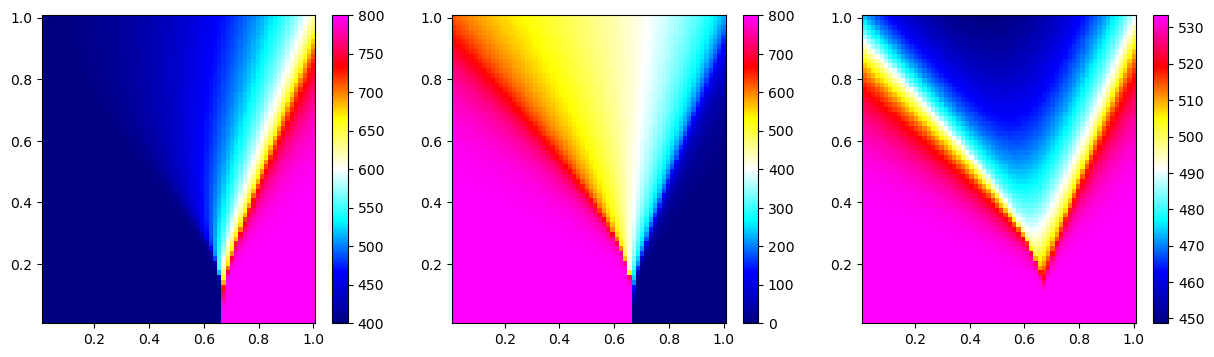

In [11]:
mean_obss = np.mean(isnnn_data[1]['obss'], axis=(0, 3))
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
lambda0_range = np.arange(1, 65) / 64
lambda1_range = lambda0_range
for i, ax in enumerate(axs[:2]):
    pc = ax.pcolormesh(
        lambda0_range, lambda1_range, mean_obss[:, :, i].T,
        cmap=classifim.bench.plot_tools.spiral_background2_cmap,
        shading='nearest')
    fig.colorbar(pc)
t = 2/3
pc = axs[2].pcolormesh(
    lambda0_range, lambda1_range, (t * mean_obss[:, :, 0] + (1 - t) * mean_obss[:, :, 1]).T,
    cmap=classifim.bench.plot_tools.spiral_background2_cmap,
    shading='nearest')
fig.colorbar(pc)

### Load GS FIMs

In [15]:
def load_gs_fims():
    gs_fims = {}
    gs_fim_mgrids = {}
    for seed in range(1, 11):
        filename = os.path.join(DATASETS_DIR, f"seed{seed:02d}", "gs_fim.parquet")
        if os.path.isfile(filename):
            gs_fim_raw = pd.read_parquet(filename)
        else:
            filename = os.path.join(DATASETS_DIR, f"seed{seed:02d}", "gs_fim.npz")
            if not os.path.isfile(filename):
                continue
            gs_fim_raw = np.load(filename)
        gs_fim = classifim.bench.fidelity.as_data_frame(gs_fim_raw, decode=True, skip_scalars=True)
        gs_fim_mgrid = classifim.bench.fidelity.meshgrid_transform_2D_fim(gs_fim)
        gs_fims[seed] = gs_fim
        gs_fim_mgrids[seed] = gs_fim_mgrid
    return gs_fims, gs_fim_mgrids

gs_fims, gs_fim_mgrids = load_gs_fims()
print(f"Loaded gs_fims for seeds {list(gs_fims.keys())}.")

Loaded gs_fims for seeds [1, 2, 3, 4, 5, 6, 7, 8, 9, 10].


### Kalz et al data

Here we "load" the data from Ansgar Kalz and Andreas Honecker's paper "Analysis of the phase transition for the Ising model on the frustrated square lattice", Fig 2.

In [18]:
def get_kalz_fig2_data():
    df = pd.read_csv(io.StringIO("""
x,t
0, 2.267605633802817
0.25050100200400816, 2.267605633802817
0.49098196392785587, 2.26056338028169
0.751503006012024, 2.2535211267605635
1.002004008016032, 2.23943661971831
1.2625250501002003, 2.221830985915493
1.5130260521042087, 2.204225352112676
1.7635270541082162, 2.1795774647887325
2.014028056112224, 2.1514084507042255
2.2645290581162323, 2.119718309859155
2.5150300601202407, 2.0809859154929575
2.7955911823647286, 2.0316901408450705
3.1462925851703405, 1.9577464788732395
3.5871743486973946, 1.841549295774648
3.8677354709418834, 1.75
4.188376753507013, 1.6161971830985915
4.569138276553106, 1.4014084507042253
4.829659318637273, 1.1584507042253522
4.929859719438877, 1.01056338028169
4.979959919839679, 0.880281690140845
5.0501002004008, 0.341549295774648
5.060120240480961, 0.390845070422535
5.080160320641282, 0.4577464788732395
5.160320641282564, 0.6373239436619718
5.34068136272545, 0.8661971830985915
5.851703406813627, 1.2535211267605633
6.8937875751503, 1.6091549295774648
9.989979959919838, 1.943661971830986"""))
    df["x1"] = np.where(df["x"] < 5, df["x"] * 2 / 5, 2.0 + (df["x"] - 5.0) * 8 / 5.0)
    df["jnn"] = np.where(df["x1"] < 2, df["x1"], 1)
    df["jnnn"] = np.where(df["x1"] < 2, 1, 1 / df["x1"])
    df["lambda0"] = df["jnn"] / (df["jnn"] + df["jnnn"])
    df["lambda1"] = df["t"] / (df["jnn"] + df["jnnn"]) / 2.5
    return df
kalz_fig2_data = get_kalz_fig2_data()

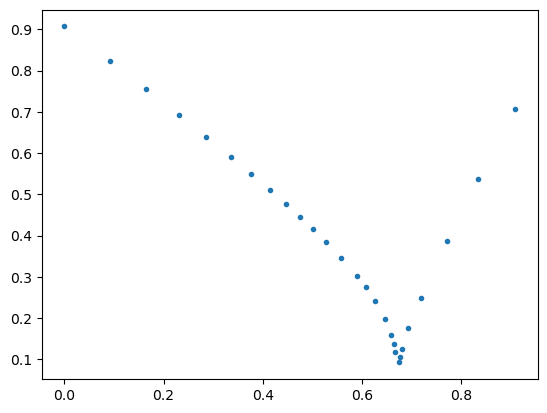

In [19]:
fig, ax = plt.subplots()
ax.plot(kalz_fig2_data["lambda0"], kalz_fig2_data["lambda1"], '.');

## Compare GS FIM with Kalz et al

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/phase_0.png'.


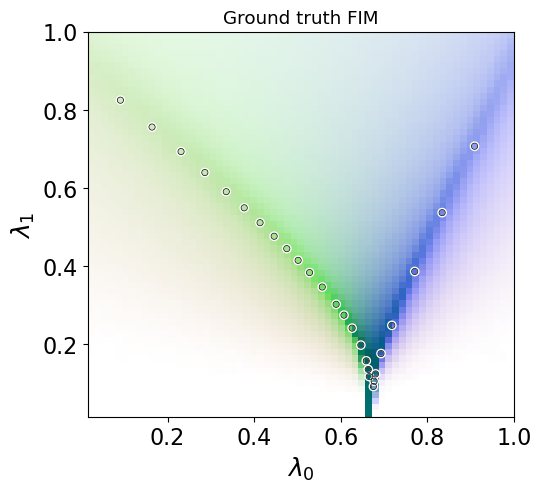

In [21]:
seed = 2

FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
res = plt.rcParams.update({'font.size': 11})
fig, ax2 = plt.subplots(ncols=1, figsize=(5.5, 5))

zz_max = 160
zz_max = classifim.bench.plot_tools.plot_fim_mgrid(ax2, gs_fim_mgrids[seed], zz_max=zz_max, xlim=(1/64, 1), ylim=(1/64, 1))
ax2.set_title("Ground truth FIM")
ax2.scatter(kalz_fig2_data["lambda0"], kalz_fig2_data["lambda1"], s=30, edgecolors='white', facecolors='none', linewidth=1.5)
ax2.scatter(kalz_fig2_data["lambda0"], kalz_fig2_data["lambda1"], s=20, edgecolors='black', facecolors='none', linewidth=0.5)
# print(f"{zz_max=:.3f}")
file_name = os.path.join(FIG_DIR, f"phase_0.png")
fig.savefig(file_name, bbox_inches='tight', dpi=600)
print(f"Saved to '{file_name}'.")